# Dependencies

In [1]:
!pip install -q scikit-learn pandas numpy nltk matplotlib seaborn
!pip install -q kaggle

In [2]:
import os
from pathlib import Path
import pandas as pd
import numpy as np

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Prepare Data

Download the data if not in kaggle

In [3]:
competition_name = "commonlit-evaluate-student-summaries"
is_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if is_kaggle:
    input_path = Path(f"/kaggle/input/{competition_name}")
else:
    input_path = Path.home() / ".kaggle" / "input" / competition_name
    !kaggle competitions download -p {input_path.parent} {competition_name}
    !unzip -o {input_path}.zip -d {input_path}

commonlit-evaluate-student-summaries.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /home/krm/.kaggle/input/commonlit-evaluate-student-summaries.zip
  inflating: /home/krm/.kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv  
  inflating: /home/krm/.kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv  
  inflating: /home/krm/.kaggle/input/commonlit-evaluate-student-summaries/sample_submission.csv  
  inflating: /home/krm/.kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv  
  inflating: /home/krm/.kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv  


Load the csv files.

In [4]:
summ_train_df = pd.read_csv(input_path / "summaries_train.csv")
summ_test_df = pd.read_csv(input_path / "summaries_test.csv")
prompts_train_df = pd.read_csv(input_path / "prompts_train.csv")
prompts_test_df = pd.read_csv(input_path / "prompts_test.csv")

Merge the summaries and prompts dataframes for both training and testing

In [15]:
train_df = pd.merge(summ_train_df, prompts_train_df, on="prompt_id")
test_df = pd.merge(summ_test_df, prompts_test_df, on="prompt_id")
train_df

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
1,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
2,0095993991fe,814d6b,The third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,00c20c6ddd23,814d6b,The experimen was orginally about how even whe...,0.567975,0.969062,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
4,00d40ad10dc9,814d6b,The third wave developed so quickly due to the...,-0.910596,-0.081769,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
...,...,...,...,...,...,...,...,...
7160,fef3e85236e5,39c16e,"It has to be made on a complex storyline, with...",-0.981265,-1.548900,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
7161,ff0f65eecf02,39c16e,Aristotle descirbes an ideal tradgedy as being...,-0.511077,-1.589115,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
7162,ff186473ea0a,39c16e,A tragedy should have a complex plan not a sim...,-0.834946,-0.593749,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
7163,ff5e9e6068da,39c16e,Aristotle believed that the ideal tradegy shou...,-0.157460,-0.165811,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...


We can do some data analysis..

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7165 entries, 0 to 7164
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   student_id       7165 non-null   object 
 1   prompt_id        7165 non-null   object 
 2   text             7165 non-null   object 
 3   content          7165 non-null   float64
 4   wording          7165 non-null   float64
 5   prompt_question  7165 non-null   object 
 6   prompt_title     7165 non-null   object 
 7   prompt_text      7165 non-null   object 
dtypes: float64(2), object(6)
memory usage: 447.9+ KB


In [7]:
train_df.describe()

,content,wording
count,7165.000000,7165.000000
mean,-0.014853,-0.063072
std,1.043569,1.036048
min,-1.729859,-1.962614
25%,-0.799545,-0.872720
50%,-0.093814,-0.081769
75%,0.499660,0.503833
max,3.900326,4.310693


Plot the correlation between the two scores. Looks like they're positively correlated

<Axes: xlabel='content', ylabel='wording'>

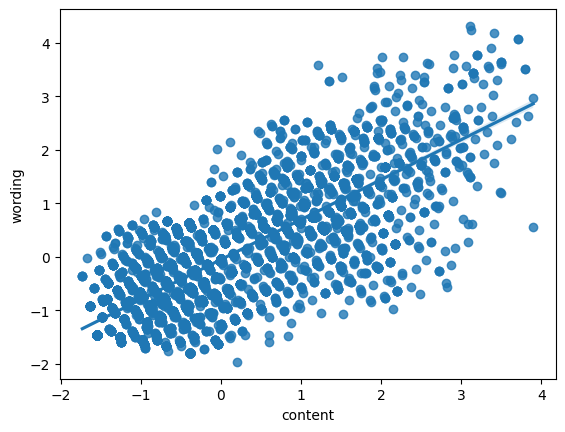

In [10]:
sns.regplot(x=train_df.content, y=train_df.wording)

In [ ]:
We can also look at their joint distribution.

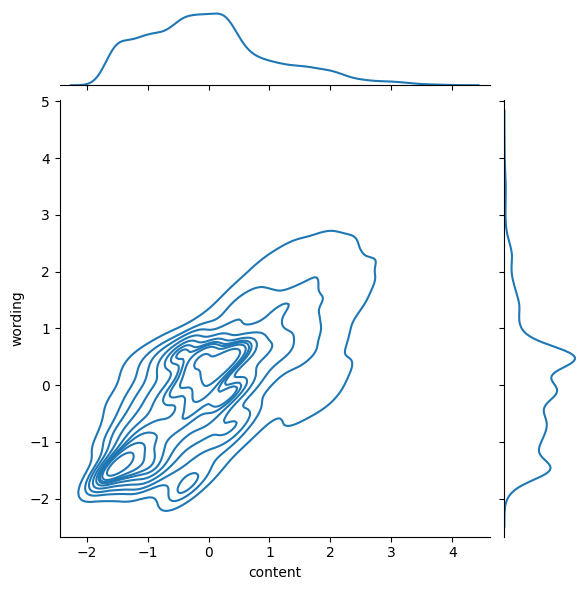

In [14]:
sns.jointplot(x=train_df.content, y=train_df.wording, kind="kde")

Looks like there are 2 discernible clusters

Some basic feature engineering on the summary texts.

# Fit Model

# Inference

# Submission